In [1]:
import sys
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [2]:
data = pd.read_excel(r"../../data/Rice_MSC_Dataset.xlsx")


In [20]:
data.to_csv("../../data/rice_msc_dataset.csv", index=False)


In [3]:
data.head()


,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ,CLASS
0,7805,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985,0.3547,4.3693,...,113.9924,65.0610,59.5989,104.8552,67.8779,63.0828,0.3673,0.3793,0.4733,Basmati
1,7503,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767,0.6637,1.9807,...,105.7055,64.3685,62.2084,96.8375,65.5371,63.5832,0.3014,0.3144,0.3641,Arborio
2,5124,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271,0.4760,3.0482,...,109.7155,62.6423,58.7439,100.2352,68.9753,59.8342,0.3233,0.3445,0.4448,Jasmine
3,7990,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272,0.6274,3.9325,...,116.5405,64.9069,60.2562,107.2560,67.3298,63.2237,0.3880,0.4020,0.4904,Basmati
4,7433,342.893,140.3350,68.3927,0.8732,97.2830,0.9831,7561,0.6006,2.0519,...,107.7502,64.7071,61.3549,98.8704,66.2048,63.5378,0.3184,0.3303,0.3928,Arborio


In [4]:
# Sprawdzamy czy są jakieś missing values
data.isnull().values.any()  # Są
ile_brakuje = data.isnull().sum()
print(ile_brakuje)


AREA            0
PERIMETER       0
MAJOR_AXIS      0
MINOR_AXIS      0
ECCENTRICITY    0
               ..
ALLdaub4Cr      0
ALLdaub4XX      0
ALLdaub4YY      0
ALLdaub4ZZ      0
CLASS           0
Length: 107, dtype: int64


In [5]:
ile_brakuje[ile_brakuje > 0]


skewB         6
kurtosisB     6
skewCb        3
skewCr        2
kurtosisCb    3
kurtosisCr    2
dtype: int64

In [6]:
# Usunę wiersze z brakującymi wartosciami.

data2 = data.dropna()  # Nowe dane
len(data.index) - len(
    data2.index
)  # Czyli było 8 wierszy z brakującymi zmiennymi

data2 = data2.reset_index()


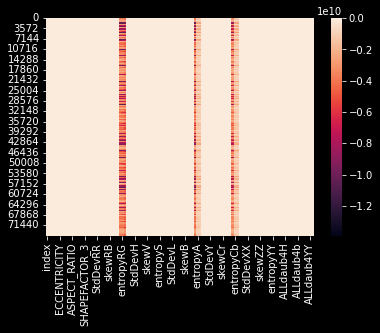

In [7]:
data3 = data2.drop(["CLASS"], axis=1)

# Macierz korelacji
# Zbadamy skorelowanie poszczególnych zmiennych (docelowo objasniających),
# żeby zdecydować których nie ma sensu wspólnie używać przy przewidywaniu rodzaju ryżu.

sns.heatmap(data3)  # chyba nie bardzo

M = data3.corr()


In [8]:
M[abs(M) > 0.9] = "Mocno"


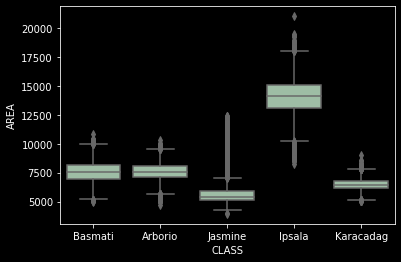

In [9]:
data_powierzchnia = data2[["AREA", "CLASS"]]

box_area = sns.boxplot(
    x="CLASS", y="AREA", data=data_powierzchnia, color="#99c2a2"
)


In [10]:
Ipsala = data_powierzchnia.loc[data_powierzchnia["CLASS"] == "Ipsala"]
Ipsala = Ipsala.reset_index()


In [11]:
Ipsala[(Ipsala["AREA"] > 12500) & (Ipsala["AREA"] < 15000)].shape[
    0
]  # ponad połowa wartosci w srodku boxplota: 8827


8827

In [12]:
Ipsala[Ipsala["AREA"] > 17000].shape[0]  # 260


260

In [13]:
Ipsala[Ipsala["AREA"] > 20000].shape[0]  # 1 mocny outlier


1

In [14]:
Ipsala[Ipsala["AREA"] < 10000].shape[0]  # 111


111

In [15]:
Ipsala["AREA"].mean(), Ipsala["AREA"].median()


(14048.670868347339, 14134.0)

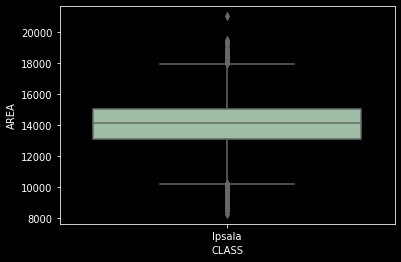

In [16]:
ax2 = sns.boxplot(x="CLASS", y="AREA", data=Ipsala, color="#99c2a2")


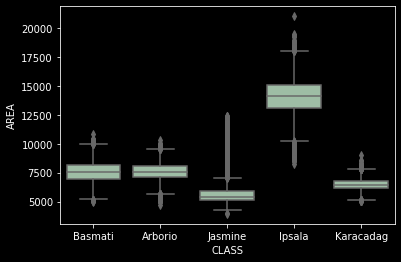

In [17]:
ax = sns.boxplot(x="CLASS", y="AREA", data=data_powierzchnia, color="#99c2a2")
# Boxplot stworzony dla wszystkich typów ryżu wskazuje na to, że są istotne różnice w powierzchni jeżeli chodzi o Ipsala, Karacadag, Jasmine,
# natomiast zbadanie powierzchni nie odróżni nam od siebie Basmati i Arborio.


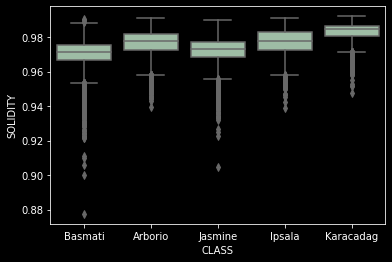

In [18]:
data_trwalosc = data2[["SOLIDITY", "CLASS"]]

box_trwalosc = sns.boxplot(
    x="CLASS", y="SOLIDITY", data=data_trwalosc, color="#99c2a2"
)


In [19]:
# Powinno nam odróżnić basmati od arborio
# KNN
X, Y = data[["AREA", "SOLIDITY"]], data["CLASS"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
przewidziane = knn.predict(X_test)

print(classification_report(Y_test, przewidziane))


              precision    recall  f1-score   support

     Arborio       0.48      0.49      0.48      1525
     Basmati       0.52      0.51      0.52      1506
      Ipsala       0.98      0.98      0.98      1432
     Jasmine       0.82      0.83      0.82      1460
   Karacadag       0.73      0.71      0.72      1577

    accuracy                           0.70      7500
   macro avg       0.70      0.70      0.70      7500
weighted avg       0.70      0.70      0.70      7500

